<a href="https://colab.research.google.com/github/AnanyaJain3/Spacecraft-Trajectory-Optimization/blob/main/D*%20Star%20Lite/D_star_2_Dimentional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
import os
import sys
import math
import matplotlib.pyplot as plt


In [ ]:
 !unzip PathPlanning-master.zip

Archive:  PathPlanning-master.zip
   creating: PathPlanning-master/
  inflating: __MACOSX/._PathPlanning-master  
  inflating: PathPlanning-master/.DS_Store  
  inflating: __MACOSX/PathPlanning-master/._.DS_Store  
  inflating: PathPlanning-master/LICENSE  
  inflating: __MACOSX/PathPlanning-master/._LICENSE  
   creating: PathPlanning-master/Sampling_based_Planning/
  inflating: __MACOSX/PathPlanning-master/._Sampling_based_Planning  
  inflating: PathPlanning-master/README.md  
  inflating: __MACOSX/PathPlanning-master/._README.md  
   creating: PathPlanning-master/CurvesGenerator/
  inflating: __MACOSX/PathPlanning-master/._CurvesGenerator  
   creating: PathPlanning-master/Search_based_Planning/
  inflating: __MACOSX/PathPlanning-master/._Search_based_Planning  
   creating: PathPlanning-master/.idea/
  inflating: __MACOSX/PathPlanning-master/._.idea  
   creating: PathPlanning-master/Sampling_based_Planning/rrt_3D/
  inflating: __MACOSX/PathPlanning-master/Sampling_based_Planning/

In [ ]:
# Specify the full path to the directory you want to add to sys.path
directory_path = os.path.abspath("/content/PathPlanning-master/Search_based_Planning")

# Append the directory to sys.path
sys.path.append(directory_path)


In [ ]:
from Search_2D import plotting, env

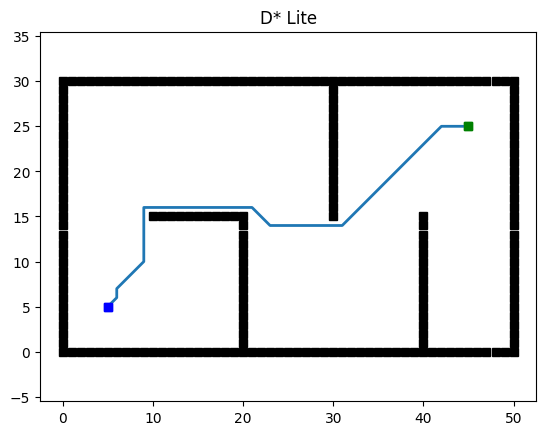

In [ ]:
class DStar:
    def __init__(self, s_start, s_goal, heuristic_type):
        self.s_start, self.s_goal = s_start, s_goal
        self.heuristic_type = heuristic_type

        self.Env = env.Env()  # class Env
        self.Plot = plotting.Plotting(s_start, s_goal)

        self.u_set = self.Env.motions  # feasible input set
        self.obs = self.Env.obs  # position of obstacles
        self.x = self.Env.x_range
        self.y = self.Env.y_range

        self.g, self.rhs, self.U = {}, {}, {}
        self.km = 0

        for i in range(1, self.Env.x_range - 1):
            for j in range(1, self.Env.y_range - 1):
                self.rhs[(i, j)] = float("inf")
                self.g[(i, j)] = float("inf")

        self.rhs[self.s_goal] = 0.0
        self.U[self.s_goal] = self.CalculateKey(self.s_goal)
        self.visited = set()
        self.count = 0
        self.fig = plt.figure()

    def run(self):
        self.Plot.plot_grid("D* Lite")
        self.ComputePath()
        self.plot_path(self.extract_path())
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        plt.show()

    def on_press(self, event):
        x, y = event.xdata, event.ydata
        if x < 0 or x > self.x - 1 or y < 0 or y > self.y - 1:
            print("Please choose right area!")
        else:
            x, y = int(x), int(y)
            print("Change position: s =", x, ",", "y =", y)

            s_curr = self.s_start
            s_last = self.s_start
            i = 0
            path = [self.s_start]

            while s_curr != self.s_goal:
                s_list = {}

                for s in self.get_neighbor(s_curr):
                    s_list[s] = self.g[s] + self.cost(s_curr, s)
                s_curr = min(s_list, key=s_list.get)
                path.append(s_curr)

                if i < 1:
                    self.km += self.h(s_last, s_curr)
                    s_last = s_curr
                    if (x, y) not in self.obs:
                        self.obs.add((x, y))
                        plt.plot(x, y, 'sk')
                        self.g[(x, y)] = float("inf")
                        self.rhs[(x, y)] = float("inf")
                    else:
                        self.obs.remove((x, y))
                        plt.plot(x, y, marker='s', color='white')
                        self.UpdateVertex((x, y))
                    for s in self.get_neighbor((x, y)):
                        self.UpdateVertex(s)
                    i += 1

                    self.count += 1
                    self.visited = set()
                    self.ComputePath()

            self.plot_visited(self.visited)
            self.plot_path(path)
            self.fig.canvas.draw_idle()

    def ComputePath(self):
        while True:
            s, v = self.TopKey()
            if v >= self.CalculateKey(self.s_start) and \
                    self.rhs[self.s_start] == self.g[self.s_start]:
                break

            k_old = v
            self.U.pop(s)
            self.visited.add(s)

            if k_old < self.CalculateKey(s):
                self.U[s] = self.CalculateKey(s)
            elif self.g[s] > self.rhs[s]:
                self.g[s] = self.rhs[s]
                for x in self.get_neighbor(s):
                    self.UpdateVertex(x)
            else:
                self.g[s] = float("inf")
                self.UpdateVertex(s)
                for x in self.get_neighbor(s):
                    self.UpdateVertex(x)

    def UpdateVertex(self, s):
        if s != self.s_goal:
            self.rhs[s] = float("inf")
            for x in self.get_neighbor(s):
                self.rhs[s] = min(self.rhs[s], self.g[x] + self.cost(s, x))
        if s in self.U:
            self.U.pop(s)

        if self.g[s] != self.rhs[s]:
            self.U[s] = self.CalculateKey(s)

    def CalculateKey(self, s):
        return [min(self.g[s], self.rhs[s]) + self.h(self.s_start, s) + self.km,
                min(self.g[s], self.rhs[s])]

    def TopKey(self):
        """
        :return: return the min key and its value.
        """

        s = min(self.U, key=self.U.get)
        return s, self.U[s]

    def h(self, s_start, s_goal):
        heuristic_type = self.heuristic_type  # heuristic type

        if heuristic_type == "manhattan":
            return abs(s_goal[0] - s_start[0]) + abs(s_goal[1] - s_start[1])
        else:
            return math.hypot(s_goal[0] - s_start[0], s_goal[1] - s_start[1])

    def cost(self, s_start, s_goal):
        """
        Calculate Cost for this motion
        :param s_start: starting node
        :param s_goal: end node
        :return:  Cost for this motion
        :note: Cost function could be more complicate!
        """

        if self.is_collision(s_start, s_goal):
            return float("inf")

        return math.hypot(s_goal[0] - s_start[0], s_goal[1] - s_start[1])

    def is_collision(self, s_start, s_end):
        if s_start in self.obs or s_end in self.obs:
            return True

        if s_start[0] != s_end[0] and s_start[1] != s_end[1]:
            if s_end[0] - s_start[0] == s_start[1] - s_end[1]:
                s1 = (min(s_start[0], s_end[0]), min(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
            else:
                s1 = (min(s_start[0], s_end[0]), max(s_start[1], s_end[1]))
                s2 = (max(s_start[0], s_end[0]), min(s_start[1], s_end[1]))

            if s1 in self.obs or s2 in self.obs:
                return True

        return False

    def get_neighbor(self, s):
        nei_list = set()
        for u in self.u_set:
            s_next = tuple([s[i] + u[i] for i in range(2)])
            if s_next not in self.obs:
                nei_list.add(s_next)

        return nei_list

    def extract_path(self):
        """
        Extract the path based on the PARENT set.
        :return: The planning path
        """

        path = [self.s_start]
        s = self.s_start

        for k in range(100):
            g_list = {}
            for x in self.get_neighbor(s):
                if not self.is_collision(s, x):
                    g_list[x] = self.g[x]
            s = min(g_list, key=g_list.get)
            path.append(s)
            if s == self.s_goal:
                break

        return list(path)

    def plot_path(self, path):
        px = [x[0] for x in path]
        py = [x[1] for x in path]
        plt.plot(px, py, linewidth=2)
        plt.plot(self.s_start[0], self.s_start[1], "bs")
        plt.plot(self.s_goal[0], self.s_goal[1], "gs")

    def plot_visited(self, visited):
        color = ['gainsboro', 'lightgray', 'silver', 'darkgray',
                 'bisque', 'navajowhite', 'moccasin', 'wheat',
                 'powderblue', 'skyblue', 'lightskyblue', 'cornflowerblue']

        if self.count >= len(color) - 1:
            self.count = 0

        for x in visited:
            plt.plot(x[0], x[1], marker='s', color=color[self.count])


def main():
    s_start = (5, 5)
    s_goal = (45, 25)

    dstar = DStar(s_start, s_goal, "euclidean")
    dstar.run()


if __name__ == '__main__':
    main()

